# Reconocimento de horas en relos analógico

Se utiliza el [dataset de relojes de Kaggles](https://www.kaggle.com/datasets/gpiosenka/time-image-datasetclassification) para entrenar un modelo de reconocimiento de horas en relojes analógicos.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
import zipfile
import numpy as np
import os


In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
def imshow(pImage):
    plt.imshow(cv2.cvtColor(pImage.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.axis("off")

## Decompresión de imágenes

Descomprimir dataset para trabajar con ello. Estos ficheros no se subiran al github

In [4]:
local_zip = './tmp/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./Assets/dataset')
zip_ref.close()

## Lectura de datos

## Lectura fichero csv

In [5]:
root_dir = './Assets/dataset'
csv_data = pd.read_csv(os.path.join(root_dir,'clocks.csv'))

In [6]:
hours_dict = pd.Series(csv_data['labels'].values, index=csv_data['class index']).to_dict()

In [7]:
train_labels = csv_data[csv_data['data set'] == "train"]['class index'].values
test_labels = csv_data[csv_data['data set'] == "test"]['class index'].values
valid_labels = csv_data[csv_data['data set'] == "valid"]['class index'].values

train_images_dir = csv_data[csv_data['data set'] == "train"]['filepaths'].values
test_images_dir = csv_data[csv_data['data set'] == "test"]['filepaths'].values
valid_images_dir = csv_data[csv_data['data set'] == "valid"]['filepaths'].values

In [8]:
print("Train shape", train_labels.shape)
print("Test shape", test_labels.shape)
print("Valid shape", valid_labels.shape)

Train shape (11520,)
Test shape (1440,)
Valid shape (1440,)


In [9]:
print("Class types", len(np.unique(train_labels)))

Class types 144


### Mostrar imagenes aleatorias

[ 7270   860  5390  5191 11284  5734  6265   466  4426  5578 11363 11111
  8322  1685   769 10583  6949  2433]


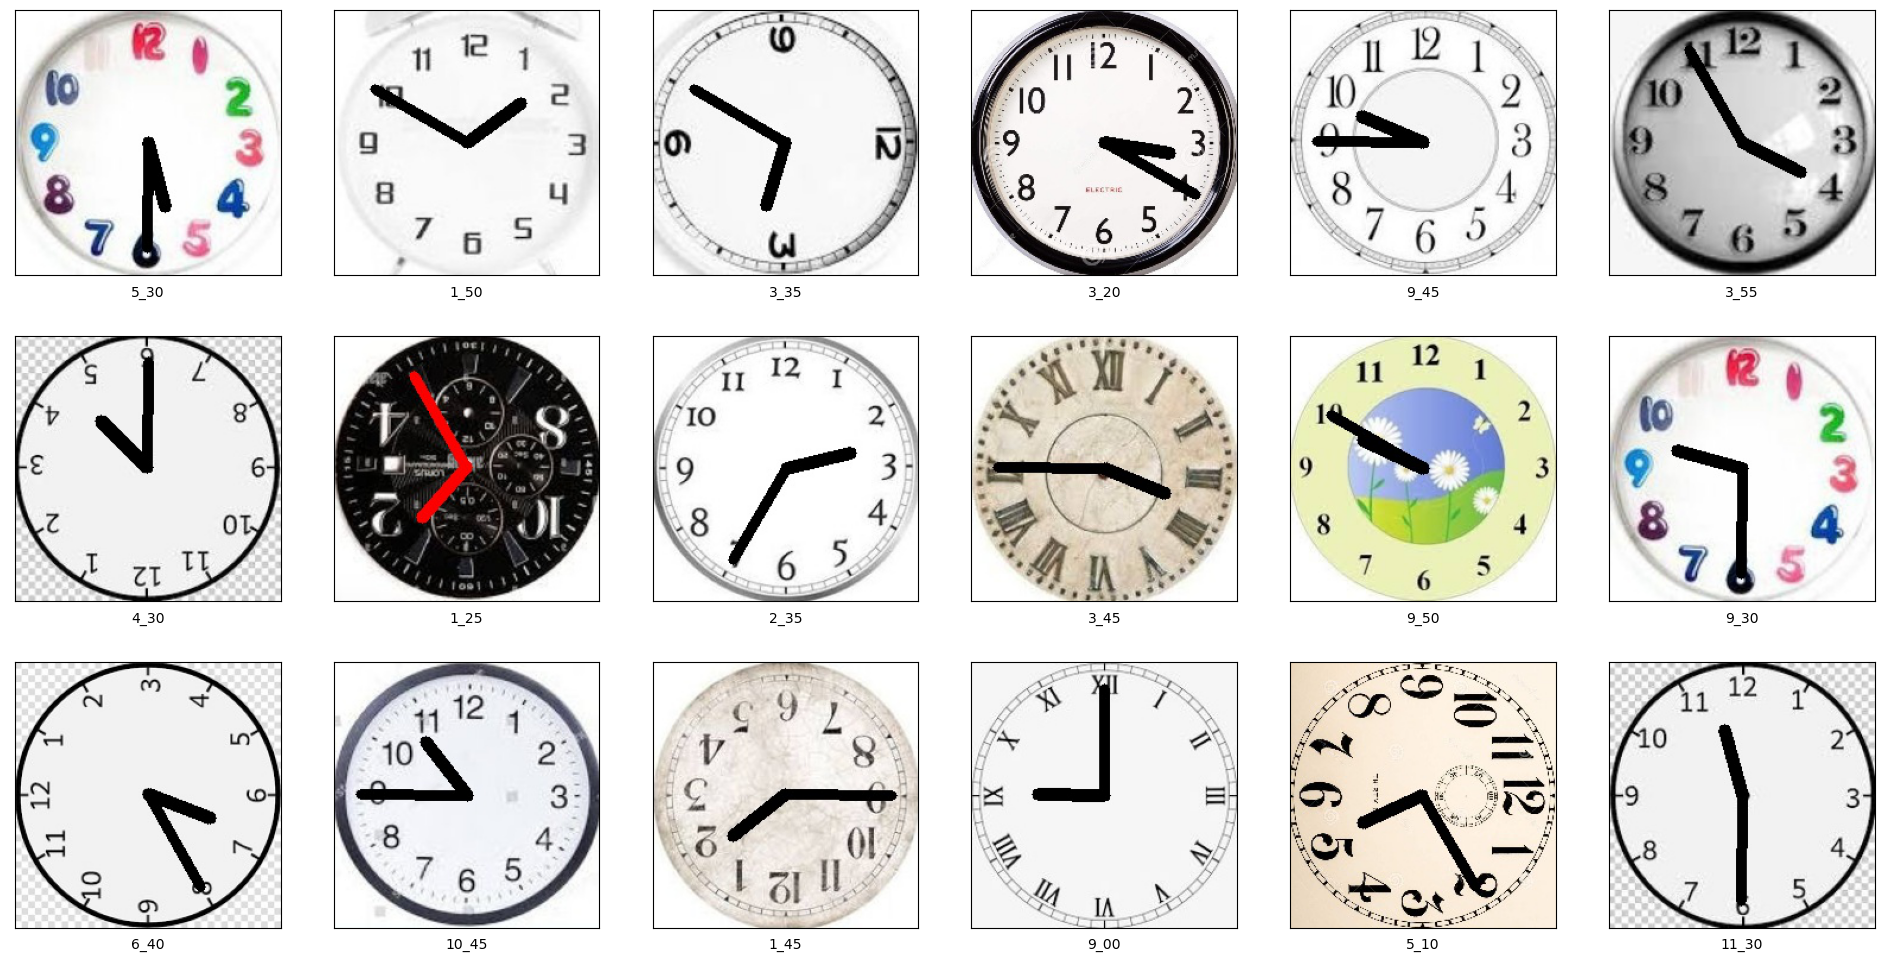

In [10]:
nrows = 3
ncols = 6



fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

idx = np.random.randint(0, len(train_images_dir), size=(nrows * ncols))

labels_filepaths = csv_data.loc[idx, ['labels','filepaths']].values
labels = csv_data.loc[idx, ['labels']].values
filepaths = csv_data.loc[idx, ['filepaths']].values
# next_images = csv_data['filepaths'].sample(n=nrows * ncols).values
print(idx)

for i, label in enumerate(labels):
  # coge el ndarray correcto y el elemento 0 ya que solo tiene ese valor
  img_path = filepaths[i][0]
  full_img_path = os.path.join(root_dir, img_path)

  sp = plt.subplot(nrows, ncols, i + 1)
  plt.xticks([])
  plt.yticks([]) 
  plt.grid(False)

  img = mpimg.imread(full_img_path)
  plt.imshow(img)
  plt.xlabel(label[0])

plt.show()

### Cargar las imagenes en memoria

In [11]:
train_images_full_dir = [root_dir + "/" +  fname for fname in train_images_dir]
train_images = np.array([cv2.imread(fname, ) for fname in train_images_full_dir])

test_images_full_dir = [root_dir + "/" +  fname for fname in test_images_dir]
test_images = np.array([cv2.imread(fname, ) for fname in test_images_full_dir])

valid_images_full_dir = [root_dir + "/" +  fname for fname in valid_images_dir]
valid_images = np.array([cv2.imread(fname, ) for fname in valid_images_full_dir])

In [12]:
print("Image shape", train_images[0].shape)

Image shape (224, 224, 3)


In [13]:
for image in train_images:
    if(train_images[0].shape != (224, 224, 3)):
        print("Image shape", image.shape)

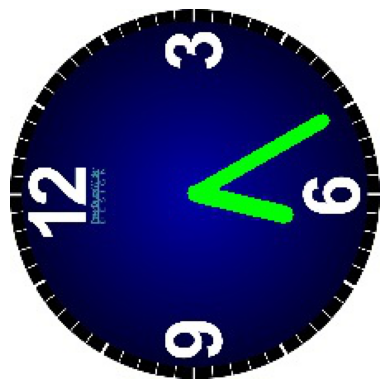

In [14]:
imshow(train_images[8154])

## Procesamiento de datos

In [15]:
model = tf.keras.Sequential([
tf.keras.layers.Input(shape=(224, 224, 3)),
tf.keras.layers.Rescaling(1./255),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
tf.keras.layers.MaxPooling2D(pool_size=2),
tf.keras.layers.Dropout(0.25),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(144, activation='softmax')
]);


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     7

In [17]:
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])

epochs = 5


history = model.fit(x= train_images, y=train_labels, epochs=epochs, batch_size=8, validation_data=(test_images, test_labels))



Epoch 1/5
1440/1440 [==============================] - 46s 30ms/step - loss: 2.5167 - accuracy: 0.4776 - val_loss: 0.6538 - val_accuracy: 0.8396
Epoch 2/5
1440/1440 [==============================] - 43s 30ms/step - loss: 0.2944 - accuracy: 0.9360 - val_loss: 0.1019 - val_accuracy: 0.9764
Epoch 3/5
1440/1440 [==============================] - 43s 30ms/step - loss: 0.0848 - accuracy: 0.9842 - val_loss: 0.0592 - val_accuracy: 0.9854
Epoch 4/5
1440/1440 [==============================] - 43s 30ms/step - loss: 0.0684 - accuracy: 0.9929 - val_loss: 0.0503 - val_accuracy: 0.9910
Epoch 5/5
1440/1440 [==============================] - 43s 30ms/step - loss: 0.0636 - accuracy: 0.9947 - val_loss: 0.1903 - val_accuracy: 0.9875


In [19]:
print("Train score:", model.evaluate(train_images, train_labels))
print("Test score:", model.evaluate(test_images, test_labels))

360/360 [==============================] - 5s 14ms/step - loss: 0.0520 - accuracy: 0.9970
Train score: [0.052020903676748276, 0.9970486164093018]
45/45 [==============================] - 1s 14ms/step - loss: 0.1903 - accuracy: 0.9875
Test score: [0.19030708074569702, 0.987500011920929]


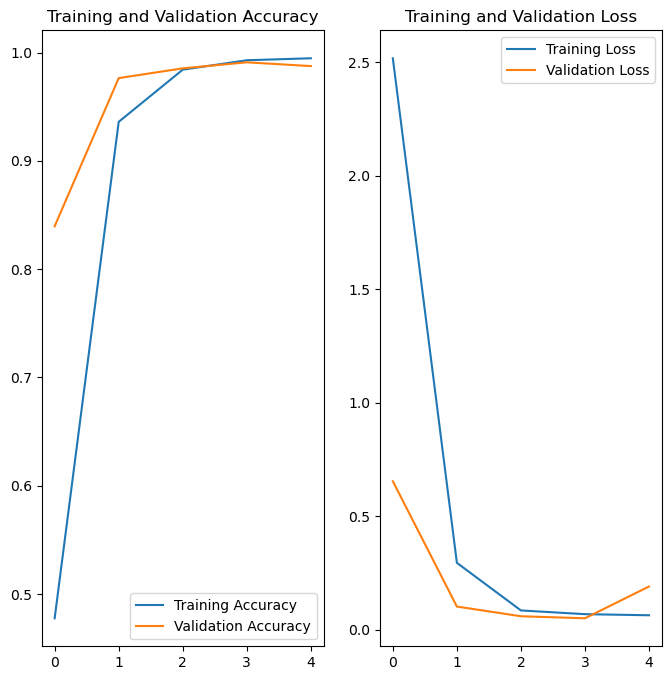

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [45]:
print(test_images[0].shape)

el = 100;

res = model.predict(test_images[1021:1022]).argmax(axis=1)[0]
print(res)

(224, 224, 3)
102


## Pruebas

[ 2806   537  5986  1841 10647  8716  6971  5625  2950  7992  4780  2368
  6655  8173  4495 10893  9163  6002]


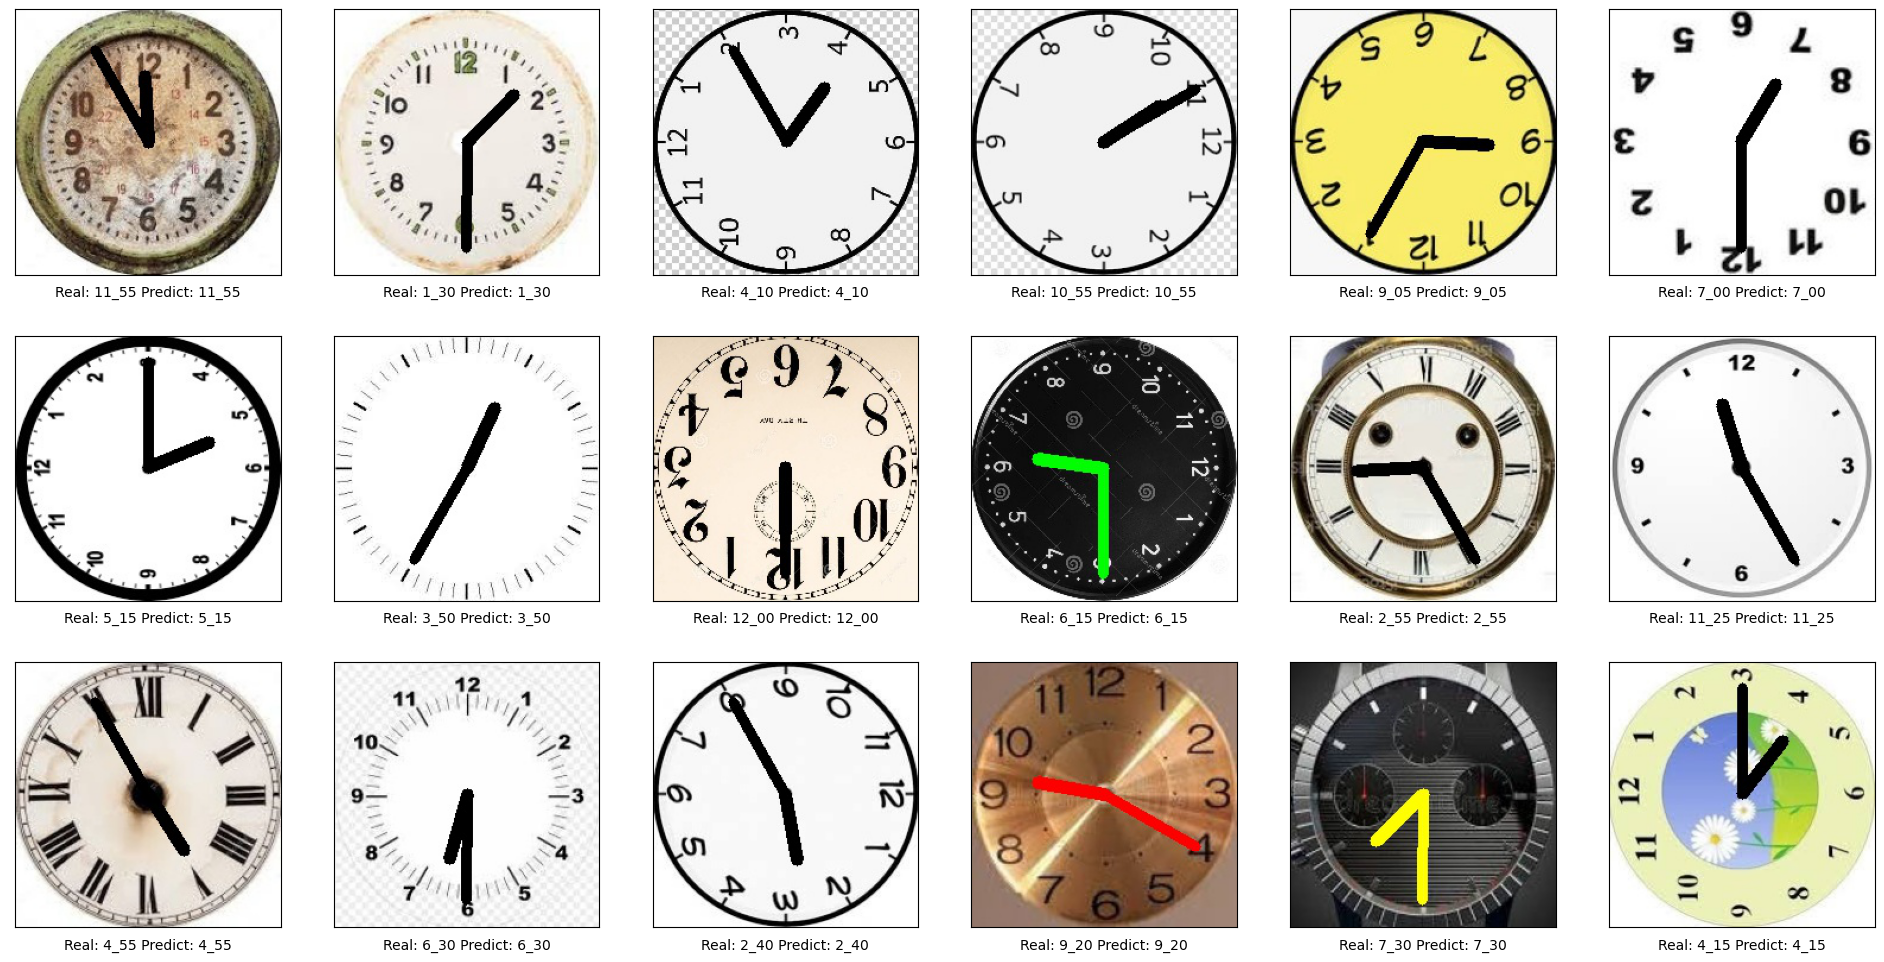

In [63]:
nrows = 3
ncols = 6



fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

idx = np.random.randint(0, len(train_images_dir), size=(nrows * ncols))

labels_filepaths = csv_data[csv_data['data set'] == "train"].loc[idx, ['labels','filepaths']].values
labels = csv_data[csv_data['data set'] == "train"].loc[idx, ['labels']].values
filepaths = csv_data[csv_data['data set'] == "train"].loc[idx, ['filepaths']].values
# next_images = csv_data['filepaths'].sample(n=nrows * ncols).values
print(idx)

for i, label in enumerate(labels):
  # coge el ndarray correcto y el elemento 0 ya que solo tiene ese valor
  img_path = filepaths[i][0]
  full_img_path = os.path.join(root_dir, img_path)

  id = idx[i]
  res = model.predict(train_images[id:(id+1)]).argmax(axis=1)[0]
  prediction_hour = hours_dict[res]

  sp = plt.subplot(nrows, ncols, i + 1)
  plt.xticks([])
  plt.yticks([]) 
  plt.grid(False)

  img = mpimg.imread(full_img_path)
  plt.imshow(img)
  plt.xlabel("Real: " + label[0] + " Predict: " + prediction_hour)

plt.show()